<a href="https://colab.research.google.com/github/acg12/AlgoBC_DeepLearning_FinalProject/blob/main/notebooks/03_Methodology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # splitting train and validation data

# For visualizing images
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import random
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# For augmenting data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For modelling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential, layers
import tensorflow_hub as hub
from sklearn.model_selection import StratifiedKFold

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Bootcamp/Bootcamp 4/Chest_xray_Corona_Metadata.csv')

train_df = df[df['Dataset_type'] == 'TRAIN']
test_df = df[df['Dataset_type'] == 'TEST']

TRAIN_DIR = '/content/drive/MyDrive/Bootcamp/Bootcamp 4/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
TEST_DIR = '/content/drive/MyDrive/Bootcamp/Bootcamp 4/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'

In [5]:
filled_train_df = train_df.fillna('Unknown')
filled_test_df = test_df.fillna('Unknown')

final_train_df = filled_train_df[['X_ray_image_name', 'Label']]
final_test_df = test_df.fillna('Unknown')

final_train_df.shape

(5286, 2)

In [6]:
train_data, valid_data = train_test_split(final_train_df, test_size=0.2, stratify=final_train_df['Label'], random_state=42)
print(train_data['Label'].value_counts())
print(valid_data['Label'].value_counts())

Pnemonia    3155
Normal      1073
Name: Label, dtype: int64
Pnemonia    789
Normal      269
Name: Label, dtype: int64


# Preprocessing

Let's augment the data so it will be more generalized.

In [7]:
non_aug_gen = ImageDataGenerator(rescale=1/255.)
aug_gen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=[0.9, 1.25],
    brightness_range=[0.5, 1.5]
)

# ------------ Grayscale -------------
non_aug_train = non_aug_gen.flow_from_dataframe(
    dataframe=train_data,
    directory=TRAIN_DIR,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary', 
    color_mode='grayscale',
    shuffle=True
)

non_aug_valid = non_aug_gen.flow_from_dataframe(
    dataframe=valid_data,
    directory=TRAIN_DIR,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True
)

non_aug_test = non_aug_gen.flow_from_dataframe(
    dataframe=final_test_df,
    directory=TEST_DIR,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True
)

aug_train = aug_gen.flow_from_dataframe(
    dataframe=train_data,
    directory=TRAIN_DIR,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True
)

# ----------- RGB --------------
non_aug_train_rgb = non_aug_gen.flow_from_dataframe(
    dataframe=train_data,
    directory=TRAIN_DIR,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary', 
    color_mode='rgb',
    shuffle=True
)

non_aug_valid_rgb = non_aug_gen.flow_from_dataframe(
    dataframe=valid_data,
    directory=TRAIN_DIR,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

non_aug_test_rgb = non_aug_gen.flow_from_dataframe(
    dataframe=final_test_df,
    directory=TEST_DIR,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

# --------- For predicting ---------------
predict_valid_gs = non_aug_gen.flow_from_dataframe(
    dataframe=valid_data,
    directory=TRAIN_DIR,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

predict_valid_rgb = non_aug_gen.flow_from_dataframe(
    dataframe=valid_data,
    directory=TRAIN_DIR,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

predict_test_rgb = non_aug_gen.flow_from_dataframe(
    dataframe=final_test_df,
    directory=TEST_DIR,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 4228 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 4228 validated image filenames belonging to 2 classes.
Found 4228 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


# Baseline Model

In [8]:
def create_baseline():
    model = Sequential([
      Conv2D(filters=10, 
             kernel_size=3, 
             strides=1,
             padding='valid',
             activation='relu', 
             input_shape=(224, 224, 1)),
      Conv2D(10, 3, activation='relu'),
      Conv2D(10, 3, activation='relu'),
      Flatten(),
      Dense(1, activation='sigmoid')
    ])
    return model

In [9]:
# Plot the validation and training data separately
def plot_learning_curves(*histories):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  fig = make_subplots(rows=3, cols=1, subplot_titles=('Loss', 'Recall', 'AUC'))
  for history in histories:
    loss = history[1].history.get('loss')
    val_loss = history[1].history.get('val_loss')

    auc = history[1].history.get('auc')
    val_auc = history[1].history.get('val_auc')
    
    recall = history[1].history.get('recall')
    val_recall = history[1].history.get('val_recall')

    epochs = np.arange(1, len(history[1].history.get('loss')) + 1)

    fig.add_trace(go.Scatter(x=epochs, y=loss, name=history[0] + " train"), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=val_loss, name=history[0] + " val"), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=recall, name=history[0] + " train"), row=2, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=val_recall, name=history[0] + " val"), row=2, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=auc, name=history[0] + " train"), row=3, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=val_auc, name=history[0] + "val"), row=3, col=1)

  # Update xaxis properties
  fig.update_xaxes(title_text="Epochs", row=1, col=1)
  fig.update_xaxes(title_text="Epochs", row=2, col=1)
  fig.update_xaxes(title_text="Epochs", row=3, col=1)

  # Update yaxis properties
  fig.update_yaxes(title_text="Loss", row=1, col=1)
  fig.update_yaxes(title_text="Recall", row=2, col=1)
  fig.update_yaxes(title_text="AUC", row=3, col=1)

  fig.update_layout(title_text="Learning Curves", height=1500)

  fig.show()

In [10]:
def plot_roc_curve(*datas):
  fig = go.Figure()
  for data in datas:
    name = data[0]
    y_true = data[1]
    pred = data[2]

    fpr, tpr, _ = roc_curve(y_true, pred)
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name))
    
  fig.update_yaxes(title_text="TPR")
  fig.update_xaxes(title_text="FPR")
  fig.update_layout(title_text="ROC Curve")
  fig.show()

In [11]:
def evaluate_model(y_true, pred, threshold=0.5):
  pred_new = [1 if i > threshold else 0 for i in pred]
  
  # Print classification report
  print('===== Classification Report ======')
  print(classification_report(y_true, pred_new))
  print()

  # Print confusion matrix
  print('===== Confusion Matrix =====')
  print(confusion_matrix(y_true, pred_new))
  print()

  # Print other metrics
  print('===== Other Metrics =====')
  roc_auc = keras.metrics.AUC(curve='ROC')
  roc_auc.update_state(y_true, pred)
  print(f"ROC_AUC: {roc_auc.result().numpy()}")

In [12]:
metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc', curve='ROC')
]
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
callbacks_baseline = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

## Train Baseline Model without Augmented Data

In [13]:
(create_baseline()).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      100       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 218, 218, 10)      910       
_________________________________________________________________
flatten (Flatten)            (None, 475240)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 475241    
Total params: 477,161
Trainable params: 477,161
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Set random seed
tf.random.set_seed(42)

# Create the baseline model
model_1 = create_baseline()

# Compile and fit
model_1.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=metrics)

history_1 = model_1.fit(non_aug_train,
                        epochs=10,
                        validation_data=non_aug_valid,
                        steps_per_epoch=len(non_aug_train),
                        validation_steps=len(non_aug_valid),
                        callbacks=callbacks_baseline)

Epoch 1/10
133/133 [==============================] - 2114s 16s/step - loss: 0.3389 - tp: 2981.0000 - fp: 372.0000 - tn: 701.0000 - fn: 174.0000 - accuracy: 0.8709 - precision: 0.8891 - recall: 0.9448 - auc: 0.8990 - val_loss: 0.1423 - val_tp: 751.0000 - val_fp: 11.0000 - val_tn: 258.0000 - val_fn: 38.0000 - val_accuracy: 0.9537 - val_precision: 0.9856 - val_recall: 0.9518 - val_auc: 0.9876
Epoch 2/10
133/133 [==============================] - 66s 497ms/step - loss: 0.1123 - tp: 3085.0000 - fp: 104.0000 - tn: 969.0000 - fn: 70.0000 - accuracy: 0.9588 - precision: 0.9674 - recall: 0.9778 - auc: 0.9890 - val_loss: 0.1046 - val_tp: 777.0000 - val_fp: 24.0000 - val_tn: 245.0000 - val_fn: 12.0000 - val_accuracy: 0.9660 - val_precision: 0.9700 - val_recall: 0.9848 - val_auc: 0.9894
Epoch 3/10
133/133 [==============================] - 65s 492ms/step - loss: 0.0617 - tp: 3112.0000 - fp: 51.0000 - tn: 1022.0000 - fn: 43.0000 - accuracy: 0.9778 - precision: 0.9839 - recall: 0.9864 - auc: 0.9967

## Train Baseline Model with Augmented Data

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create the 2nd baseline model
model_2 = create_baseline()

# Compile and fit
model_2.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=metrics)

history_2 = model_2.fit(aug_train,
                        epochs=10,
                        validation_data=non_aug_valid,
                        steps_per_epoch=len(aug_train),
                        validation_steps=len(non_aug_valid),
                        callbacks=callbacks_baseline)

Epoch 1/10
133/133 [==============================] - 93s 682ms/step - loss: 0.4950 - tp: 3770.0000 - fp: 796.0000 - tn: 546.0000 - fn: 174.0000 - accuracy: 0.7798 - precision: 0.8257 - recall: 0.9559 - auc: 0.8376 - val_loss: 0.4571 - val_tp: 775.0000 - val_fp: 213.0000 - val_tn: 56.0000 - val_fn: 14.0000 - val_accuracy: 0.7854 - val_precision: 0.7844 - val_recall: 0.9823 - val_auc: 0.7983
Epoch 2/10
133/133 [==============================] - 89s 669ms/step - loss: 0.3119 - tp: 2913.0000 - fp: 310.0000 - tn: 763.0000 - fn: 242.0000 - accuracy: 0.8694 - precision: 0.9038 - recall: 0.9233 - auc: 0.9215 - val_loss: 0.3152 - val_tp: 777.0000 - val_fp: 127.0000 - val_tn: 142.0000 - val_fn: 12.0000 - val_accuracy: 0.8686 - val_precision: 0.8595 - val_recall: 0.9848 - val_auc: 0.9303
Epoch 3/10
133/133 [==============================] - 89s 670ms/step - loss: 0.2770 - tp: 2927.0000 - fp: 278.0000 - tn: 795.0000 - fn: 228.0000 - accuracy: 0.8803 - precision: 0.9133 - recall: 0.9277 - auc: 0.9

## Conclusion

In [ ]:
# Compare model 1 and model 2 learning curves
plot_learning_curves(['With_Augment', history_1], ['Without_Augment', history_2])

In [ ]:
# Look at the better model's learning curves
plot_learning_curves(['Model_1', history_1])

It looks like our model trained on non-augmented data performed better. Let's evaluate it further.

In [ ]:
predict_valid_gs.reset()
pred = model_1.predict(predict_valid_gs)

predict_valid_gs.reset()
pred_2 = model_2.predict(predict_valid_gs)

y_true = [0 if x == 'Normal' else 1 for x in valid_data['Label']]

plot_roc_curve(['Model_1', y_true, pred], ['Model_2', y_true, pred_2])

In [ ]:
# Model_1 is the better model, judging from its learning curves and ROC curve; let's evaluate it
evaluate_model(y_true, pred)

===== Classification Report ======
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       269
           1       0.98      0.98      0.98       789

    accuracy                           0.97      1058
   macro avg       0.96      0.96      0.96      1058
weighted avg       0.97      0.97      0.97      1058


===== Confusion Matrix =====
[[251  18]
 [ 16 773]]

===== Other Metrics =====
ROC_AUC: 0.989229142665863


In [ ]:
# For comparison
model_1.evaluate(predict_valid_gs)

34/34 [==============================] - 14s 418ms/step - loss: 0.1063 - tp: 773.0000 - fp: 18.0000 - tn: 251.0000 - fn: 16.0000 - accuracy: 0.9679 - precision: 0.9772 - recall: 0.9797 - auc: 0.9892


[0.10626493394374847,
 773.0,
 18.0,
 251.0,
 16.0,
 0.967863917350769,
 0.9772440195083618,
 0.979721188545227,
 0.989229142665863]

Using augmented data actually hurt our model's performance, so from now on, we are not going to augment our data. Our baseline model actually performed really well.

As we can see from this model's ROC curve, this model is a really good classifier.

# Using Pretrained Models

After reading some articles, I decided that using pretrained models that were trained on the ImageNet dataset would probably help in predicting these lung images. So, I picked out these models to see which one of them would perform better.

You can try reading these for starters:

* https://towardsdatascience.com/does-imagenet-pretraining-work-for-chest-radiography-images-covid-19-2e2d9f5f0875

* https://arxiv.org/pdf/1902.07208.pdf

I chose to use models from the DenseNet and ResNet architecture family, because with most experiments I found, these two models seemed to perform well with radiology images. I also chose EfficientNet just to see how it would fare with the other two.

In [ ]:
def create_model(model_url, num_classes=1):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
  model_url (str): A TensorFlow Hub feature extraction URL.
  num_classes (int): Number of output neurons in output layer,
  should be equal to number of target classes, default 10.

  Returns:
  An uncompiled Keras Sequential model with model_url as feature
  extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                          trainable=False, # freeze the underlying patterns
                                          name='feature_extraction_layer',
                                          input_shape=(224, 224, 3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

  return model

In [16]:
efficientnetv2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2'

MODEL_HISTORY = []

## ResNetV2-50

In [ ]:
tf.random.set_seed(42)

# Get the model
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

# Build the model
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
out = base_model(inputs, training=False)
out = layers.GlobalMaxPooling2D()(out)
out = layers.Dense(1, activation='sigmoid', name='output_layer')(out)
model_resnet = keras.Model(inputs, out)

# Compile model
model_resnet.compile(loss='binary_crossentropy',
                    optimizer=Adam(learning_rate=5e-5),
                    metrics=metrics)

# Train the model
history_resnet = model_resnet.fit(non_aug_train_rgb, epochs=30,
                                  validation_data=non_aug_valid_rgb,
                                  steps_per_epoch=len(non_aug_train_rgb),
                                  validation_steps=len(non_aug_valid_rgb),
                                  callbacks=callbacks)

# Save history
MODEL_HISTORY.append(['ResNetV2-50', history_resnet])

Epoch 1/30
133/133 [==============================] - 872s 7s/step - loss: 0.9379 - tp: 3260.0000 - fp: 829.0000 - tn: 551.0000 - fn: 772.0000 - accuracy: 0.7181 - precision: 0.7973 - recall: 0.8085 - auc: 0.6449 - val_loss: 0.7543 - val_tp: 693.0000 - val_fp: 145.0000 - val_tn: 124.0000 - val_fn: 96.0000 - val_accuracy: 0.7722 - val_precision: 0.8270 - val_recall: 0.8783 - val_auc: 0.7615
Epoch 2/30
133/133 [==============================] - 83s 623ms/step - loss: 0.4987 - tp: 2802.0000 - fp: 370.0000 - tn: 703.0000 - fn: 353.0000 - accuracy: 0.8290 - precision: 0.8834 - recall: 0.8881 - auc: 0.8669 - val_loss: 0.5078 - val_tp: 719.0000 - val_fp: 103.0000 - val_tn: 166.0000 - val_fn: 70.0000 - val_accuracy: 0.8365 - val_precision: 0.8747 - val_recall: 0.9113 - val_auc: 0.8713
Epoch 3/30
133/133 [==============================] - 84s 628ms/step - loss: 0.3550 - tp: 2880.0000 - fp: 279.0000 - tn: 794.0000 - fn: 275.0000 - accuracy: 0.8690 - precision: 0.9117 - recall: 0.9128 - auc: 0.92

In [ ]:
model_resnet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, None, None, 2048)  23564800  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
plot_learning_curves(['ResNetV2-50', history_resnet])

## DenseNet-121

In [ ]:
tf.random.set_seed(42)

# Get the model
base_model = tf.keras.applications.DenseNet121(include_top=False)
base_model.trainable = False

# Build the model
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
out = base_model(inputs, training=False)
out = layers.GlobalMaxPooling2D()(out)
out = layers.Dense(1, activation='sigmoid', name='output_layer')(out)
model_dense = keras.Model(inputs, out)

# Compile the model
model_dense.compile(loss='binary_crossentropy',
                    optimizer=Adam(learning_rate=5e-5),
                    metrics=metrics)

# Train the model
history_dense = model_dense.fit(non_aug_train_rgb, epochs=30,
                                validation_data=non_aug_valid_rgb,
                                steps_per_epoch=len(non_aug_train_rgb),
                                validation_steps=len(non_aug_valid_rgb),
                                callbacks=callbacks)

# Save history
MODEL_HISTORY.append(['DenseNet-121', history_dense])

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/30
133/133 [==============================] - 95s 634ms/step - loss: 4.3781 - tp: 887.0000 - fp: 80.0000 - tn: 1262.0000 - fn: 3057.0000 - accuracy: 0.2755 - precision: 0.9173 - recall: 0.2249 - auc: 0.5918 - val_loss: 1.1271 - val_tp: 255.0000 - val_fp: 59.0000 - val_tn: 210.0000 - val_fn: 534.0000 - val_accuracy: 0.4395 - val_precision: 0.8121 - val_recall: 0.3232 - val_auc: 0.6032
Epoch 2/30
133/133 [==============================] - 79s 595ms/step - loss: 0.7971 - tp: 2190.0000 - fp: 714.0000 - tn: 359.0000 - fn: 965.0000 - accuracy: 0.6029 - precision: 0.7541 - recall: 0.6941 - auc: 0.5323 - val_loss: 0.6598 - val_tp: 670.0000 - val_fp: 199.0000 - val_tn: 70.0000 - val_fn: 119.0000 - val_accuracy: 0.6994 - val_precision: 0.7710 - val_recall: 0.8492 - val_auc: 0.6115
Epoch 3/30
133/133 [==============================] - 77s 577ms/step - loss: 0.6253 - tp: 2687.0000 - fp: 797.0000 - tn: 276.0000 - fn: 468.0000 

In [ ]:
model_dense.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 1024)              0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
plot_learning_curves(['DenseNet121', history_dense])

## EfficientNetV2-B0

In [ ]:
tf.random.set_seed(42)

# Build model
model_efficientnet = create_model(efficientnetv2_url)

# Compile model
model_efficientnet.compile(loss='binary_crossentropy',
                           optimizer=Adam(learning_rate=5e-5),
                           metrics=metrics)

# Train the model
history_efficientnet = model_efficientnet.fit(non_aug_train_rgb, epochs=30,
                                              validation_data=non_aug_valid_rgb,
                                              steps_per_epoch=len(non_aug_train_rgb),
                                              validation_steps=len(non_aug_valid_rgb),
                                              callbacks=callbacks)

# Save history
MODEL_HISTORY.append(['EfficientNetV2-B0', history_efficientnet])

Epoch 1/30
133/133 [==============================] - 85s 567ms/step - loss: 0.7459 - tp: 2287.0000 - fp: 541.0000 - tn: 801.0000 - fn: 1657.0000 - accuracy: 0.5009 - precision: 0.8087 - recall: 0.5799 - auc: 0.6495 - val_loss: 0.5727 - val_tp: 741.0000 - val_fp: 241.0000 - val_tn: 28.0000 - val_fn: 48.0000 - val_accuracy: 0.7268 - val_precision: 0.7546 - val_recall: 0.9392 - val_auc: 0.6182
Epoch 2/30
133/133 [==============================] - 73s 551ms/step - loss: 0.5325 - tp: 3095.0000 - fp: 1044.0000 - tn: 29.0000 - fn: 60.0000 - accuracy: 0.7389 - precision: 0.7478 - recall: 0.9810 - auc: 0.6909 - val_loss: 0.4986 - val_tp: 782.0000 - val_fp: 264.0000 - val_tn: 5.0000 - val_fn: 7.0000 - val_accuracy: 0.7439 - val_precision: 0.7476 - val_recall: 0.9911 - val_auc: 0.7766
Epoch 3/30
133/133 [==============================] - 72s 543ms/step - loss: 0.4760 - tp: 3136.0000 - fp: 1047.0000 - tn: 26.0000 - fn: 19.0000 - accuracy: 0.7479 - precision: 0.7497 - recall: 0.9940 - auc: 0.8231 

In [ ]:
model_efficientnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              5919312   
_________________________________________________________________
output_layer (Dense)         (None, 1)                 1281      
Total params: 5,920,593
Trainable params: 1,281
Non-trainable params: 5,919,312
_________________________________________________________________


In [ ]:
plot_learning_curves(['EfficientNetV2-B0', history_efficientnet])

With a network that is slightly more complex than our DenseNet121, the EfficientNetV2-B0 got better learning curves. I think this model did quite well compared to the other two.

## Evaluation

In [ ]:
predict_valid_rgb.reset()
pred_resnet = model_resnet.predict(predict_valid_rgb)

predict_valid_rgb.reset()
pred_dense = model_dense.predict(predict_valid_rgb)

predict_valid_rgb.reset()
pred_efficientnet = model_efficientnet.predict(predict_valid_rgb)

y_true = [0 if x == 'Normal' else 1 for x in valid_data['Label']]

In [ ]:
plot_roc_curve(['ResNetV2-50', y_true, pred_resnet], ['DenseNet121', y_true, pred_dense], ['EfficientNetV2-B0', y_true, pred_efficientnet])

In [ ]:
print('================# ResNetV2-50 #================')
evaluate_model(y_true, pred_resnet)

================# ResNetV2-50 #================
===== Classification Report ======
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       269
           1       0.94      0.97      0.95       789

    accuracy                           0.93      1058
   macro avg       0.92      0.90      0.91      1058
weighted avg       0.93      0.93      0.93      1058


===== Confusion Matrix =====
[[222  47]
 [ 27 762]]

===== Other Metrics =====
ROC_AUC: 0.9703002572059631


In [ ]:
print('================# DenseNet121 #================')
evaluate_model(y_true, pred_dense)

================# DenseNet121 #================
===== Classification Report ======
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       269
           1       0.93      0.96      0.95       789

    accuracy                           0.92      1058
   macro avg       0.90      0.88      0.89      1058
weighted avg       0.92      0.92      0.92      1058


===== Confusion Matrix =====
[[213  56]
 [ 32 757]]

===== Other Metrics =====
ROC_AUC: 0.966396689414978


In [ ]:
print('================# EfficientNetV2-B0 #================')
evaluate_model(y_true, pred_efficientnet)

================# EfficientNetV2-B0 #================
===== Classification Report ======
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       269
           1       0.96      0.97      0.97       789

    accuracy                           0.95      1058
   macro avg       0.94      0.93      0.94      1058
weighted avg       0.95      0.95      0.95      1058


===== Confusion Matrix =====
[[240  29]
 [ 20 769]]

===== Other Metrics =====
ROC_AUC: 0.9896650314331055


Looking at these scores, it's safe to say that the model EfficientNetV2-B0 Model performed really well, getting the highest combination of AUC, recall, and loss scores.

Let's plot their metrics to see which one of them is the best.

In [ ]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

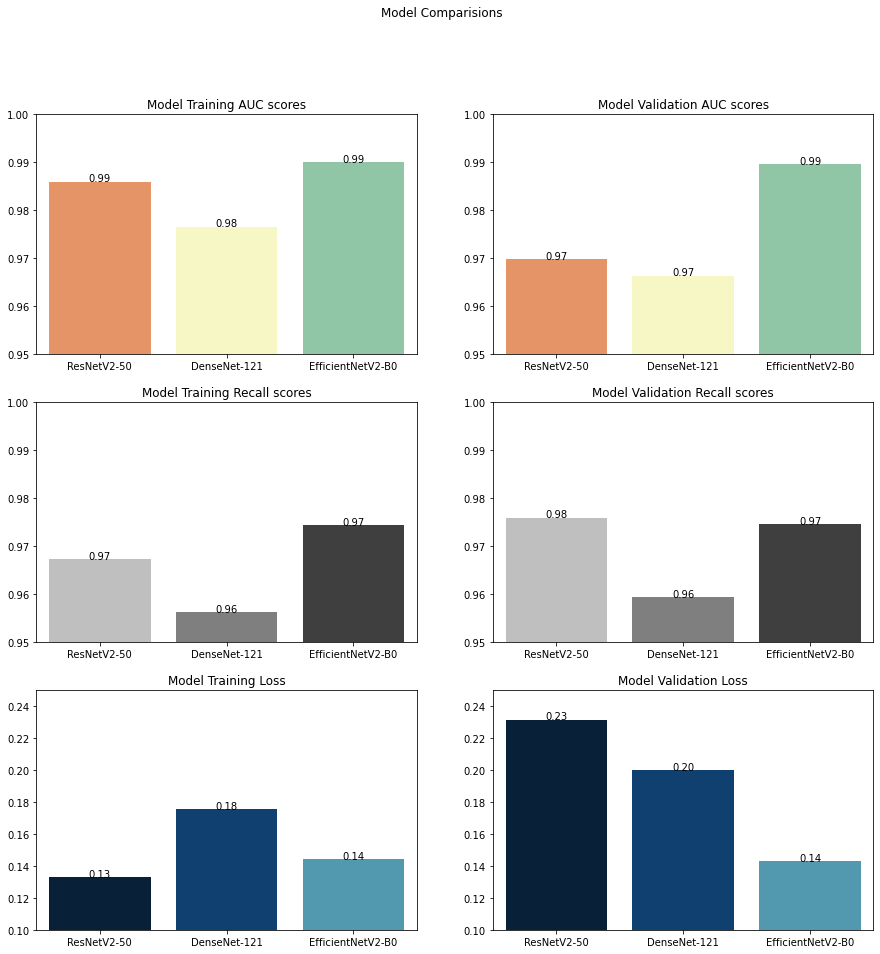

In [ ]:
HISTORY_ARRAY = np.array(MODEL_HISTORY)
model_names = HISTORY_ARRAY[:, 0]
histories = HISTORY_ARRAY[:, 1]

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('auc')[-1], histories)), ax=ax[0, 0], palette='Spectral')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('val_auc')[-1], histories)), ax=ax[0, 1], palette='Spectral')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('recall')[-1], histories)), ax=ax[1, 0], palette='gist_yarg')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('val_recall')[-1], histories)), ax=ax[1, 1], palette='gist_yarg')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('loss')[-1], histories)), ax=ax[2, 0], palette='ocean')
sns.barplot(x=model_names, y=list(map(lambda x: x.history.get('val_loss')[-1], histories)), ax=ax[2, 1], palette='ocean')

ax[0, 0].set_title('Model Training AUC scores')
ax[0, 1].set_title('Model Validation AUC scores')
ax[1, 0].set_title('Model Training Recall scores')
ax[1, 1].set_title('Model Validation Recall scores')
ax[2, 0].set_title('Model Training Loss')
ax[2, 1].set_title('Model Validation Loss')

ax[0, 0].set_ylim((0.95, 1.0))
ax[0, 1].set_ylim((0.95, 1.0))
ax[1, 0].set_ylim((0.95, 1.0))
ax[1, 1].set_ylim((0.95, 1.0))
ax[2, 0].set_ylim((0.1, 0.25))
ax[2, 1].set_ylim((0.1, 0.25))

show_values_on_bars(ax)

fig.suptitle('Model Comparisions')
plt.show()

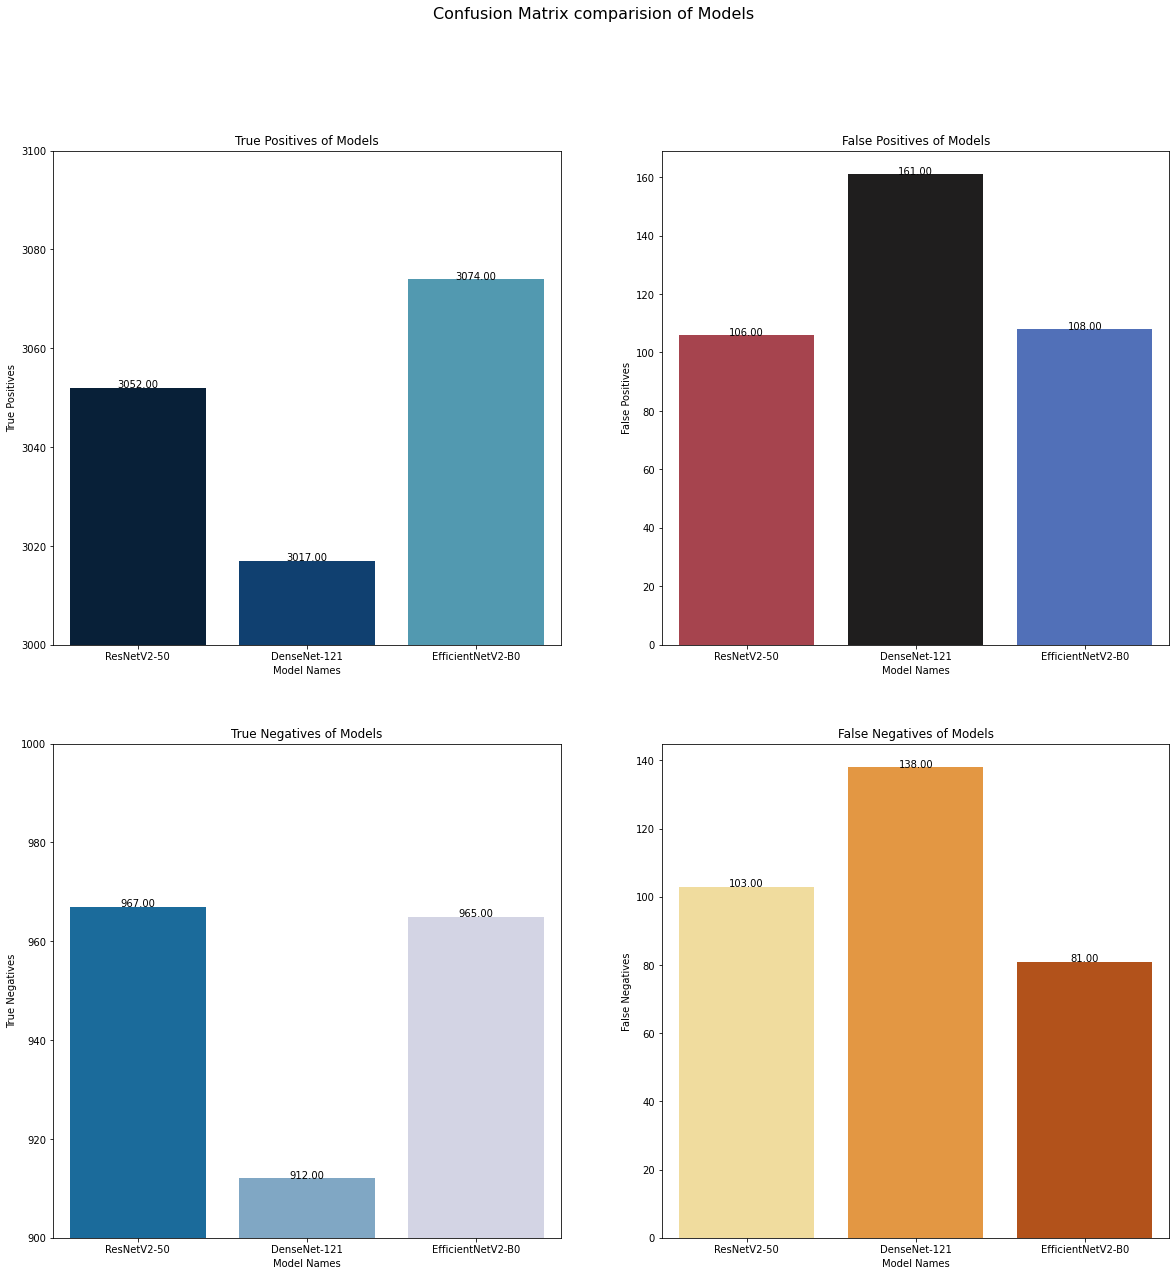

In [ ]:
model_names = HISTORY_ARRAY[:, 0]
histories = HISTORY_ARRAY[:, 1]

metric_dataframe = pd.DataFrame({
    'Model Names': model_names,
    'True Positives': list(map(lambda x: x.history.get('tp')[-1], histories)),
    'False Positives': list(map(lambda x: x.history.get('fp')[-1], histories)),
    'True Negatives': list(map(lambda x: x.history.get('tn')[-1], histories)),
    'False Negatives': list(map(lambda x: x.history.get('fn')[-1], histories))
})

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
sns.barplot(x='Model Names', y='True Positives', data=metric_dataframe, ax=ax[0, 0], palette='ocean')
sns.barplot(x='Model Names', y='False Positives', data=metric_dataframe, ax=ax[0, 1], palette='icefire_r') 
sns.barplot(x='Model Names', y='True Negatives', data=metric_dataframe, ax=ax[1, 0], palette='PuBu_r')
sns.barplot(x='Model Names', y='False Negatives', data=metric_dataframe, ax=ax[1, 1], palette='YlOrBr')

ax[0, 0].set_title('True Positives of Models')
ax[0, 0].set_ylim((3000, 3100))
ax[0, 1].set_title('False Positives of Models')
ax[1, 0].set_title('True Negatives of Models')
ax[1, 0].set_ylim((900, 1000))
ax[1, 1].set_title('False Negatives of Models')

show_values_on_bars(ax)

fig.suptitle('Confusion Matrix comparision of Models', size=16)
plt.show()

True to our prior assumptions, the EfficientNetV2-B0 performed the best, as it got the highest true positive rate and least false negative rate among the three models, with way less parameters than the ResNetV2-50 model.

In the next section, we will try to improve the EfficientNetV2-B0 model we have here, using techniques like batch normalization, dropout, and hyperparameter tuning.

# Improving Our Model Of Choice

## Batch normalization

In [ ]:
feature_extractor_layer = hub.KerasLayer(efficientnetv2_url,
                                         trainable=False, # freeze the underlying patterns
                                         name='feature_extraction_layer',
                                         input_shape=(224, 224, 3,)) # define the input image shape

model_batchnorm = tf.keras.Sequential([
    feature_extractor_layer,
    layers.BatchNormalization(),
    layers.Dense(100),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(1, activation='sigmoid', name='output_layer')     
])

# Compile model
model_batchnorm.compile(loss='binary_crossentropy',
                        optimizer=Adam(1e-4),
                        metrics=metrics)

# Train the model
history_batchnorm = model_batchnorm.fit(non_aug_train_rgb, epochs=10,
                                        validation_data=non_aug_valid_rgb,
                                        steps_per_epoch=len(non_aug_train_rgb),
                                        validation_steps=len(non_aug_valid_rgb),
                                        callbacks=callbacks)

Epoch 1/10
133/133 [==============================] - 1157s 8s/step - loss: 0.4342 - tp: 2325.0000 - fp: 24.0000 - tn: 1049.0000 - fn: 830.0000 - accuracy: 0.7980 - precision: 0.9898 - recall: 0.7369 - auc: 0.9665 - val_loss: 0.3140 - val_tp: 717.0000 - val_fp: 6.0000 - val_tn: 263.0000 - val_fn: 72.0000 - val_accuracy: 0.9263 - val_precision: 0.9917 - val_recall: 0.9087 - val_auc: 0.9912
Epoch 2/10
133/133 [==============================] - 78s 584ms/step - loss: 0.2228 - tp: 2901.0000 - fp: 21.0000 - tn: 1052.0000 - fn: 254.0000 - accuracy: 0.9350 - precision: 0.9928 - recall: 0.9195 - auc: 0.9896 - val_loss: 0.2230 - val_tp: 742.0000 - val_fp: 6.0000 - val_tn: 263.0000 - val_fn: 47.0000 - val_accuracy: 0.9499 - val_precision: 0.9920 - val_recall: 0.9404 - val_auc: 0.9946
Epoch 3/10
133/133 [==============================] - 75s 565ms/step - loss: 0.1568 - tp: 3017.0000 - fp: 37.0000 - tn: 1036.0000 - fn: 138.0000 - accuracy: 0.9586 - precision: 0.9879 - recall: 0.9563 - auc: 0.9930 

In [ ]:
model_batchnorm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              5919312   
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 100)               128100    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 101       
Total params: 6,053,033
Trainable params: 130,961
Non-trainable params: 5,922,072
________________________________________

## Dropout

In [ ]:
feature_extractor_layer = hub.KerasLayer(efficientnetv2_url,
                                         trainable=False, # freeze the underlying patterns
                                         name='feature_extraction_layer',
                                         input_shape=(224, 224, 3,)) # define the input image shape

model_dropout = tf.keras.Sequential([
    feature_extractor_layer,
    layers.BatchNormalization(),
    layers.Dense(100),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid', name='output_layer')     
])

# Compile model
model_dropout.compile(loss='binary_crossentropy',
                      optimizer=Adam(1e-4),
                      metrics=metrics)

# Train the model
history_dropout = model_dropout.fit(non_aug_train_rgb, epochs=10,
                                    validation_data=non_aug_valid_rgb,
                                    steps_per_epoch=len(non_aug_train_rgb),
                                    validation_steps=len(non_aug_valid_rgb),
                                    callbacks=callbacks)

Epoch 1/10
133/133 [==============================] - 87s 589ms/step - loss: 0.5022 - tp: 2934.0000 - fp: 60.0000 - tn: 1282.0000 - fn: 1010.0000 - accuracy: 0.7507 - precision: 0.9800 - recall: 0.7439 - auc: 0.9564 - val_loss: 0.3344 - val_tp: 728.0000 - val_fp: 11.0000 - val_tn: 258.0000 - val_fn: 61.0000 - val_accuracy: 0.9319 - val_precision: 0.9851 - val_recall: 0.9227 - val_auc: 0.9870
Epoch 2/10
133/133 [==============================] - 75s 566ms/step - loss: 0.2543 - tp: 2858.0000 - fp: 39.0000 - tn: 1034.0000 - fn: 297.0000 - accuracy: 0.9205 - precision: 0.9865 - recall: 0.9059 - auc: 0.9851 - val_loss: 0.2407 - val_tp: 744.0000 - val_fp: 6.0000 - val_tn: 263.0000 - val_fn: 45.0000 - val_accuracy: 0.9518 - val_precision: 0.9920 - val_recall: 0.9430 - val_auc: 0.9918
Epoch 3/10
133/133 [==============================] - 74s 560ms/step - loss: 0.1915 - tp: 2980.0000 - fp: 42.0000 - tn: 1031.0000 - fn: 175.0000 - accuracy: 0.9487 - precision: 0.9861 - recall: 0.9445 - auc: 0.98

In [ ]:
model_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              5919312   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               128100    
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                

## Evaluate

In [ ]:
plot_learning_curves(['BatchNorm_1_Layer', history_batchnorm], ['Batchnorm_Dropout', history_dropout])

In [ ]:
predict_valid_rgb.reset()
pred_batchnorm = model_batchnorm.predict(predict_valid_rgb)

predict_valid_rgb.reset()
pred_dropout = model_dropout.predict(predict_valid_rgb)

y_true = [0 if x == 'Normal' else 1 for x in valid_data['Label']]

plot_roc_curve(['BatchNorm', y_true, pred_batchnorm], ['BatchNorm_Dropout', y_true, pred_dropout])

In [ ]:
evaluate_model(y_true, pred_batchnorm)

===== Classification Report ======
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       269
           1       0.99      0.99      0.99       789

    accuracy                           0.98      1058
   macro avg       0.98      0.98      0.98      1058
weighted avg       0.98      0.98      0.98      1058


===== Confusion Matrix =====
[[259  10]
 [  6 783]]

===== Other Metrics =====
ROC_AUC: 0.998708963394165


In [ ]:
evaluate_model(y_true, pred_dropout)

===== Classification Report ======
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       269
           1       0.99      0.98      0.99       789

    accuracy                           0.98      1058
   macro avg       0.97      0.98      0.98      1058
weighted avg       0.98      0.98      0.98      1058


===== Confusion Matrix =====
[[262   7]
 [ 12 777]]

===== Other Metrics =====
ROC_AUC: 0.9984827637672424


Since the results between using batch normalization and batch normalization together with dropout are quite close, I'm going to stick with using dropout, in the hopes that it will result in a more generalized model.

## Reduce LR

In [17]:
feature_extractor_layer = hub.KerasLayer(efficientnetv2_url,
                                         trainable=False, # freeze the underlying patterns
                                         name='feature_extraction_layer',
                                         input_shape=(224, 224, 3,)) # define the input image shape

model_reducedlr = tf.keras.Sequential([
    feature_extractor_layer,
    layers.BatchNormalization(),
    layers.Dense(100),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid', name='output_layer')     
])

# Compile model
model_reducedlr.compile(loss='binary_crossentropy',
                        optimizer=Adam(1e-4),
                        metrics=metrics)

# Add reduced LR to callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=4,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=2, 
                                                  restore_best_weights=True)

callbacks_reducedlr = [early_stopping, reduce_lr]

# Train the model
history_reducedlr = model_reducedlr.fit(non_aug_train_rgb, epochs=15,
                                        validation_data=non_aug_valid_rgb,
                                        steps_per_epoch=len(non_aug_train_rgb),
                                        validation_steps=len(non_aug_valid_rgb),
                                        callbacks=callbacks_reducedlr)

Epoch 1/15
133/133 [==============================] - 87s 580ms/step - loss: 0.3638 - tp: 3404.0000 - fp: 149.0000 - tn: 1193.0000 - fn: 540.0000 - accuracy: 0.8496 - precision: 0.9581 - recall: 0.8631 - auc: 0.9444 - val_loss: 0.2756 - val_tp: 770.0000 - val_fp: 26.0000 - val_tn: 243.0000 - val_fn: 19.0000 - val_accuracy: 0.9575 - val_precision: 0.9673 - val_recall: 0.9759 - val_auc: 0.9888
Epoch 2/15
133/133 [==============================] - 75s 562ms/step - loss: 0.1927 - tp: 2958.0000 - fp: 53.0000 - tn: 1020.0000 - fn: 197.0000 - accuracy: 0.9409 - precision: 0.9824 - recall: 0.9376 - auc: 0.9873 - val_loss: 0.2009 - val_tp: 759.0000 - val_fp: 10.0000 - val_tn: 259.0000 - val_fn: 30.0000 - val_accuracy: 0.9622 - val_precision: 0.9870 - val_recall: 0.9620 - val_auc: 0.9951
Epoch 3/15
133/133 [==============================] - 76s 571ms/step - loss: 0.1463 - tp: 3025.0000 - fp: 53.0000 - tn: 1020.0000 - fn: 130.0000 - accuracy: 0.9567 - precision: 0.9828 - recall: 0.9588 - auc: 0.9

In [ ]:
plot_learning_curves(['Tuned_Final', history_reducedlr])

## Hyperparameter Tuning

For this particular section, I made it in another notebook. I highly recommend you check it out here: 

# Final Testing

After looking at the results of the hyperparameter tuning ...

In [22]:
non_aug_test = non_aug_gen.flow_from_dataframe(
    dataframe=final_test_df,
    directory=TEST_DIR,
    x_col='X_ray_image_name',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

Found 624 validated image filenames belonging to 2 classes.


In [23]:
# Tuned model
predict_test_rgb.reset()
pred_test_tuned = model_reducedlr.predict(predict_test_rgb)

# Baseline model
non_aug_test.reset()
pred_test = model_1.predict(non_aug_test)

y_test = [0 if x == 'Normal' else 1 for x in final_test_df['Label']]

plot_roc_curve(['Tuned Model', y_test, pred_test_tuned], ['Baseline Model', y_test, pred_test])

In [24]:
# Baseline model
evaluate_model(y_test, pred_test, threshold=1-0.02)

===== Classification Report ======
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       234
           1       0.86      0.88      0.87       390

    accuracy                           0.83       624
   macro avg       0.82      0.82      0.82       624
weighted avg       0.83      0.83      0.83       624


===== Confusion Matrix =====
[[177  57]
 [ 48 342]]

===== Other Metrics =====
ROC_AUC: 0.8805664777755737


In [44]:
# Final model results
evaluate_model(y_test, pred_test_tuned, threshold=1-0.07)

===== Classification Report ======
              precision    recall  f1-score   support

           0       0.93      0.79      0.85       234
           1       0.88      0.97      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624


===== Confusion Matrix =====
[[184  50]
 [ 13 377]]

===== Other Metrics =====
ROC_AUC: 0.9423405528068542


In [26]:
# Save model and model weights
model_reducedlr.save_weights('final_weights.h5')
model_reducedlr.save('final_model.h5')

# Last words

From the above results, our tuned model definitely showed some improvements compared to our baseline model. Our AUC score improved by **~5%**, with an average improvement in our recall score by **~3%**. About **30 less** cases of false negatives and **30 more** cases of true positives!

To further enhance my model, I might try using ensemble methods to get an optimal model that scores the highest recall without overfitting the data, but as of right now, I have limited time and resources to do that. 

For now, I think our current model performed quite well, achieving a recall score of ~88% and an AUC score of ~95%.